# Diffusion analysis
Analysis of lithium diffusion in Li<sub>6</sub>PS<sub>5</sub><i>X</i> (<i>X</i>=I, Cl)

In [1]:
import yaml
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%config InlineBackend.figure_format = 'retina'
import numpy as np

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list

import matplotlib.pyplot as plt

from pymatgen.io.vasp import Xdatcar
from sklearn.utils import resample
from msdstats import DiffusionAnalyzer, displacements_from_structures
# DiffusionAnalyzer is the pymatgen DiffusionAnalyzer class, patched to store all
# calculated squared displacements at each dt.

In [2]:
# Parameters for creating a Pymatgen DiffusionAnalyzer object
da_params = { 'specie': 'Li',
              'temperature': 500,
              'time_step': 2.0,
              'step_skip': 50,
              'min_obs': 50 }

In [3]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.safe_load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [4]:
def msd_error(sq_disp, n_sets=2000):
    """Error estimation of MSD data using bootstrapping.
    
    Args:
        sq_disp (list): List of squared displacement observations at each value of dt.
            Each list entry should be a 2D Numpy array with size [atom, sq_disp].
        n_sets (int): Number of resampled datasets to evaluate.
        
    Returns:
        (np.array): 1D array of std deviation estimates.
                    
    """
    max_obs = sq_disp[0].shape[1]
    std_err = np.array([])
    for d in tqdm_notebook(sq_disp):
        n_obs = d.shape[1]
        n_ions = d.shape[0]
        dt = max_obs - n_obs + 1
        n_samples = int(max_obs/dt*n_ions) # approximate number of "non-overlapping" observations, allowing for partial overlap
        sampled_means = [np.mean(resample(d.flatten(), n_samples=n_samples)) for i in range(n_sets)]
        # std error for the mean squared displacement at dt
        std_err = np.append(std_err, np.std(sampled_means))
    return std_err
        
def msd_95p_ci(sq_disp, n_sets=2000):
    """Error estimation of MSD 95% confidence interval using bootstrapping.
    
    Args:
        sq_disp (list): List of squared displacement observations at each value of dt.
            Each list entry should be a 2D Numpy array with size [atom, sq_disp].
        n_sets (int): Number of resampled datasets to evaluate.
        
    Returns:
        (np.array): 2D array of 2.5% and 97.% percentile values.
                    
    """
    max_obs = sq_disp[0].shape[1]
    ci = []
    for d in tqdm_notebook(sq_disp):
        n_obs = d.shape[1]
        n_ions = d.shape[0]
        dt = max_obs - n_obs + 1
        n_samples = int(max_obs/dt*n_ions) # approximate number of "non-overlapping" observations, allowing for partial overlap
        sampled_means = [np.mean(resample(d.flatten(), n_samples=n_samples)) for i in range(n_sets)]
        # 2.5% and 97.5% percentile values for the mean squared displacement at dt
        ci.append([np.percentile(sampled_means, 2.5), np.percentile(sampled_means, 97.5)])
    return np.array(ci)

In [5]:
data_dir = '../../data'
diff_data = {}
errors = {}
for system in tqdm_notebook(md_runs):
    diff_data[system] = {}
    errors[system] = {}
    for disorder, runs in tqdm_notebook(md_runs[system].items()):
        xdatcar_filenames = [ f'{data_dir}/{system}/{disorder}/run{i}/actual_XDATCAR.gz' for i in runs ]
        xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
        structures = flatten_list( [ x.structures for x in xdatcars ] )
        disp = displacements_from_structures(structures)
        da = DiffusionAnalyzer(structure=structures[0],
                           displacements=disp,
                           **da_params)
        diff_data[system][disorder] = da
        errors[system][disorder] = msd_95p_ci(da.sq_disp_store)

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


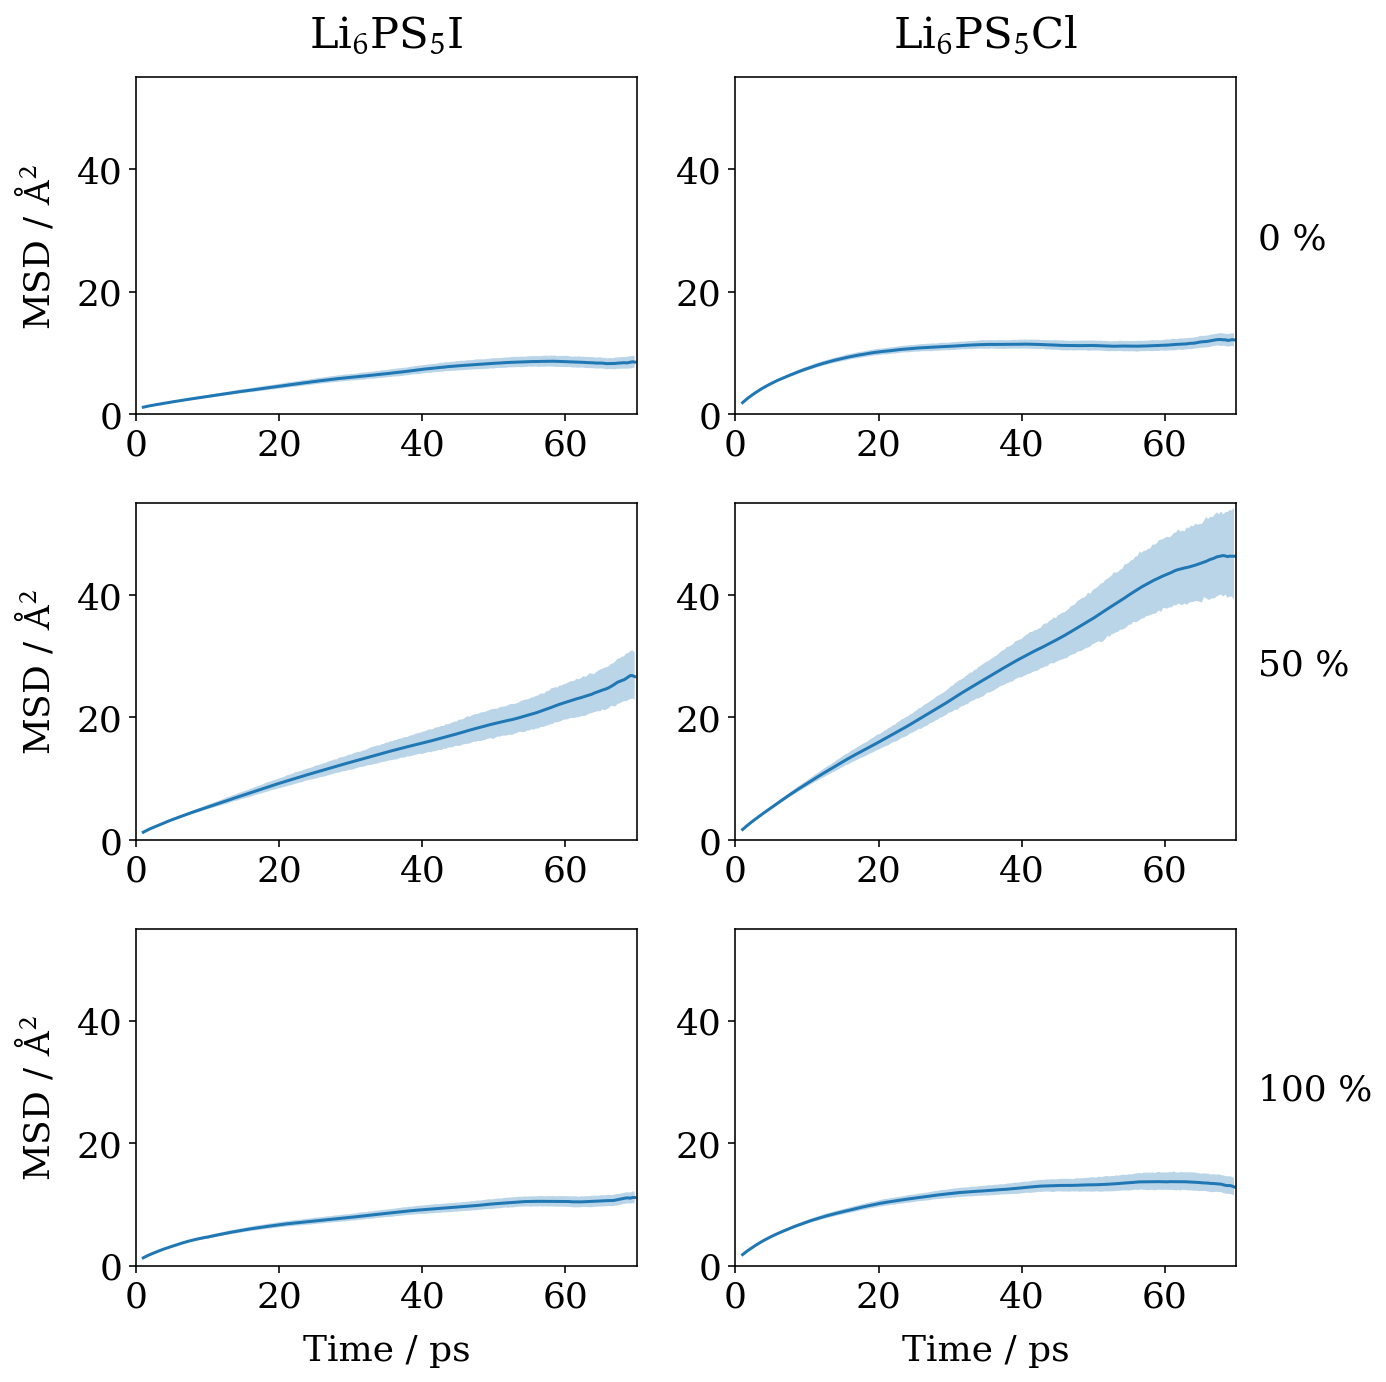

In [6]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Iowan Old Style']
rcParams['font.size'] = 18
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'

# linestyle = { 'Li6PS5I': '-',
#               'Li6PS5Cl': '-' }
# axis = { 'Li6PS5I': 0,
#          'Li6PS5Cl': 1 }
# color = { '0p':   '#4e79a7', 
#           '50p':  '#f28e2b',
#           '100p': '#59a14f' }
# legends = { 'Li6PS5I': r'I',
#             'Li6PS5Cl': r'Cl',
#             '0p': '0%',
#             '50p': '50%',
#             '100p': '100%'}

fig, ax = plt.subplots(3,2,figsize=(10,10))

data = diff_data['Li6PS5I']['0p']
ci = errors['Li6PS5I']['0p']
ax[0,0].fill_between(data.dt/1000, ci[:,0], ci[:,1], alpha=0.3)
ax[0,0].plot(data.dt/1000, data.msd)

data = diff_data['Li6PS5I']['50p']
ci = errors['Li6PS5I']['50p']
ax[1,0].fill_between(data.dt/1000, ci[:,0], ci[:,1], alpha=0.3)
ax[1,0].plot(data.dt/1000, data.msd)

data = diff_data['Li6PS5I']['100p']
ci = errors['Li6PS5I']['100p']
ax[2][0].fill_between(data.dt/1000, ci[:,0], ci[:,1], alpha=0.3)
ax[2][0].plot(data.dt/1000, data.msd)

data = diff_data['Li6PS5Cl']['0p']
ci = errors['Li6PS5Cl']['0p']
ax[0,1].fill_between(data.dt/1000, ci[:,0], ci[:,1], alpha=0.3)
ax[0,1].plot(data.dt/1000, data.msd)

data = diff_data['Li6PS5Cl']['50p']
ci = errors['Li6PS5Cl']['50p']
ax[1,1].fill_between(data.dt/1000, ci[:,0], ci[:,1], alpha=0.3)
ax[1,1].plot(data.dt/1000, data.msd)

data = diff_data['Li6PS5Cl']['100p']
ci = errors['Li6PS5Cl']['100p']
ax[2,1].fill_between(data.dt/1000, ci[:,0], ci[:,1], alpha=0.3)
ax[2,1].plot(data.dt/1000, data.msd)

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0,55])
        ax[i,j].set_xlim([0,70])
        ax[i,j].set_xticks([0,20,40,60])
        ax[i,j].set_yticks([0,20,40])
        
xlabel = r'Time / ps'
ylabel = r'MSD / $\mathrm{\AA}^2$'
# ax[2,0].set_xticks(range(5))
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set_xlabel(xlabel, labelpad=10)
ax[2,0].set_ylabel(ylabel, labelpad=10)
ax[1,0].set_ylabel(ylabel, labelpad=10)
ax[0,0].set_ylabel(ylabel, labelpad=10)
ax[2,1].set_xlabel(xlabel, labelpad=10)

ax[0,1].text(73,27,'0 %')
ax[1,1].text(73,27,'50 %')
ax[2,1].text(73,27,'100 %')
    
fig.tight_layout()    
# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../../figures/msd.pdf', bbox_inches='tight')
fig.show()